## Work flow for single cell tracing analysis for anatomy MS 2021

_Folder Preparation_<br>

all the required image files are provided under folder with the mouse name<br>
xxx/AL066/<br>
Should have:  <br>
ara2sample/<br>
ara2sample_atlas/<br>
ara2sample_bf/<br>


__Steps
1. Convert annotations to um units 
2. (V3d) Resample in 1um steps

__The result after step 2 is provided (converted and resampled annotation points)__

3. Downsample to 25ums (need to run twice for axons and dendrites). Need to save in the same folder as ara2sample_atlas/


4. Identify working with axons(is_axon=1) or not (is_axon=0)
5. read atlas_labels from provided ccf_2017_itksnap.csv provided
6. read in points and get the name of corresponding atlas, outputs points with indices in the corresponding atlas
7. generates tiff stack for points 
8. a) check if points are within the atlas brain (ie. if there are indices of 0 then some points are outside of the brain)
8. b) correct some of the issue with labeling (see details within the cell)
9. generates .xls files for number of axons in corresponding brain region. (also generate another xls that groups them by parent structure)

__Repeat for dendrites by setting is_axon= 0 in cell 6 then run the rest of the cells again__

_Note that its better to output all .xls files in the same folder (in cell 3, out_dir) for analysis_ 

10. Plot coronal, horizontal and tangential (barrel field) view of non-downsampled points with colours differentiating their location (grey, white and stratum).
11. Bar plots of # of axon in specific brain regions for each neuron (sort by most to least amount of parent structure)
12. Summary annotated heatmap (points grouped by parent structure)


In [1]:
import os
import tkinter.filedialog as fdialog
import Neuron_analysis as na
from Neuron_analysis import *
import numpy as np

import pandas as pd
import SimpleITK as sitk

KeyboardInterrupt: 

In [ ]:
na.points.downsample_anno()
# repeat for both axons and dendrites
# note that the original and goal resolution is hard coded within the Neuron_analysis module..

In [ ]:
in_dir = fdialog.askdirectory(title='Please select the input directory')
# ie: D:\2PT electroporation time\AL066
axon= fdialog.askopenfilename(title='Selecte the points for axons')
dendrite= fdialog.askopenfilename(title='Selecte the points for dendrites')

In [ ]:
out_dir='D:/Complete_points/'
mouse_name=na.find_mousename(in_dir)
out_name=out_dir+mouse_name

In [ ]:
na.points.downsample_anno()
# repeat for both axons and dendrites
# need to save under the same folder with ara2sample_atlas for na.get_pt_natlas() to work

In [ ]:
# Cell 6
is_axon=1

if is_axon==1:
    file_type=axon
elif is_axon==0:
    file_type=dendrite
# put 0 if working with dendrites

In [ ]:
# Two useful functions
def check_points(points_in_atlas):
    '''Checks whether all your points' ID is within the atlas labels
    Input: matching ID of the points (this is the second output from na.make_pd)
    '''
    id_inatlas=[]
    for x in atlas_labels['region_id']:
        intID = int(x)
        id_inatlas.append(intID)

    # need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

    num_of_zeros = [i for i, x in enumerate(points_in_atlas) if x == 0]
    # find the indices for which carries an id =0
    
    unique_id=set(points_in_atlas)
    
    for id_inbrain in unique_id:
        if id_inbrain not in id_inatlas:
            if id_inbrain==0:
                print(f'There are {len(num_of_zeros)} points with ID= {id_inbrain}, this index is outside of the brain, consider possible suboptimal image registration')
            else: 
                print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
            warnings.warn('Some points do not have corresponding labels')
    return 

def make_pd(all_points, out_name, atlas_name, axon=1):
    ''' 
    For ara2sample only
    Takes in all points (as a list, usually the output of na.refill_section or na.get_pt_natlas ) and formulates a pd structure.
    Input: downsampled points (in transformix compatible format), name of corresponding indicies of endings 
    ouputs: a pandas dataframe with anatomical regions and their corresponding total points count and ending points count, list of atlas ID for each point
    
    '''
                        
    image= sitk.ReadImage(atlas_name)
    atlas =sitk.GetArrayFromImage(image)
        
    points_in_atlas=[int(atlas[i[2], i[1],i[0]]) for i in all_points ]
    #find an ID for all points

    unique_id=set(points_in_atlas)

    our_regions=atlas_labels.loc[atlas_labels['region_id'].isin (unique_id)]

    id_withcounts=[]
    for i in unique_id:
        id_withcounts.append([i, points_in_atlas.count(i)])

    new_df= pd.DataFrame(id_withcounts, columns=['region_id', 'Total_counts'])
    our_regionWcounts=pd.merge(our_regions, new_df)
    
    if axon==1:
        out_name=out_name + 'axons_region_with_counts.xls'
    else:
        out_name=out_name + 'dendrites_region_with_counts.xls'
    
    our_regionWcounts.to_excel(out_name,index=None,header=True)

    return our_regionWcounts.sort_values(by=['Total_counts']), points_in_atlas

In [ ]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\wraped\ccf_2017_itksnap_labels.csv', sep=',')

In [ ]:
points,atlas_name=na.get_pt_natlas(file_type,in_dir)
# read points and get path name of the corresponding atlas

In [ ]:
if is_axon :
    na.atlas.make_tif_1(points, atlas_name,out_dir+mouse_name, is_axon)
else:
    na.atlas.make_tif(points, atlas_name,out_dir+mouse_name, is_axon)
# save points as a tiff file for visualization and overlay
# for dendrites, keep the intensities different since...its too cramped up and will look bad!

In [ ]:
check_points(points_in_atlas)
#we should only see id=0 as possibility now since now is using the itksnap_wraped atlas

In [ ]:
points_in_atlas= np.where(points_in_atlas==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

if is_axon :
    points_in_atlas= np.where(points_in_atlas==800 , 215 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1092 , 215 , points_in_atlas)
    # replace id= 800 (subependymal zone) and 1092 (lateral ventricle) with 215(caudoputamen)
    # especially for AL131
    
    points_in_atlas= np.where(points_in_atlas==1242, 1296 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1127, 1296 , points_in_atlas)
    # replace id= 1242 (optic radiation)  and id= 1127 (auditory radiation) with 1296, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the labels for these regions are wrong

check_points(points_in_atlas)
# check again to see if 0 disappears

In [ ]:
region_counts=na.points.make_pd_ara2sample(points_in_atlas.tolist(),atlas_labels,out_name,is_axon)
# This gives an excel file identifying number of points in a given region


## Repeat the above cells to have an excel file for all neuron. 
#### step below: associated region id on origional(non-downsampled and non-transformed) annotation (converted to um units and resampled to 1um steps)

In [ ]:
points_original= fdialog.askopenfilename(title='Selecte the original resampled points')
# asks for the non-downsampled annotation, usually the eswc file that has been converted to um and resampled at 1 um steps
# typically in petersen server analysis folder

original_withID=na.points.findID_origional(points_original, points_in_atlas,out_name,is_axon)
#makes a csv file with original points and their associated id

### Plot coronal, horizontal and bf view in higher resolution

with different colours for axons in grey matter, white matter, or striatum

Same ideas for dendrite but all dendrite are in grey matter, so it would be a simplified code for them

In [27]:
import matplotlib.pyplot as plt
import tkinter.filedialog as fdialog

import math


In [3]:
out_dir='M:\\analysis\Yanqi_Liu\\For_anatomy_manuscript\\Figures\\For_reviewers\\'


In [34]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\wraped\ccf_2017_itksnap_labels.csv', sep=',')


In [188]:
ori_pointsID= fdialog.askopenfilename(title='Selecte the original resampled points with ID excel file')
mouse_name= na.find_mousename(ori_pointsID)
out_name=out_dir+mouse_name
mouse_name

'AL092'

In [189]:
original_withID= pd.read_csv (ori_pointsID)
original_withID.head()

,x,y,z,atlasID
0,3427.11,2251.20,4225.56,845
1,3427.13,2250.80,4226.47,845
2,3427.15,2250.40,4227.39,845
3,3427.17,2250.01,4228.31,845
4,3427.20,2249.61,4229.22,844


In [190]:
full_label=pd.merge(na.atlas_labels, atlas_labels, on = 'acronym')

In [191]:
fiber_tracts=full_label[full_label['structure_id_path'].str.contains("1009")].region_id
fiber_tracts=fiber_tracts.tolist()

In [192]:
striatum=full_label[full_label['structure_id_path'].str.contains("477")].region_id
striatum=striatum.tolist()

In [193]:
white=original_withID.loc[original_withID['atlasID'].isin(fiber_tracts)]
grey=original_withID.loc[~original_withID['atlasID'].isin(fiber_tracts) & ~original_withID['atlasID'].isin(striatum)]
stri=original_withID.loc[original_withID['atlasID'].isin(striatum)]

In [208]:
white.empty

True

In [209]:
grey.empty

False

In [210]:
stri.empty

True

In [197]:
xg= pd.to_numeric(grey['x']).round()
yg= pd.to_numeric(grey['y']).round()
zg= pd.to_numeric(grey['z']).round()

xw= pd.to_numeric(white['x']).round()
yw= pd.to_numeric(white['y']).round()
zw= pd.to_numeric(white['z']).round()

xs= pd.to_numeric(stri['x']).round()
ys= pd.to_numeric(stri['y']).round()
zs= pd.to_numeric(stri['z']).round()

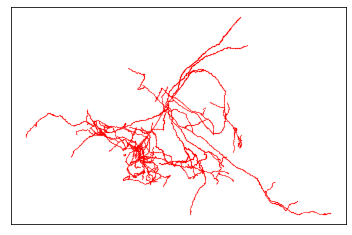

In [198]:
plt.scatter(xg[::5], yg[::5],s=0.01, c='red')
plt.scatter(xw[::5], yw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], ys[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_c_axons.svg", format='svg')

plt.show()

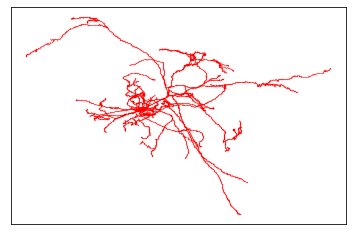

In [199]:
plt.scatter(xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_h_axons.svg", format='svg')
plt.show()
#horizontal view

In [200]:
def rotate(x,y,xo,yo,degrees): #rotate x,y around xo,yo by x degrees
    theta = np.deg2rad(degrees) # convert degrees to rad
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)  + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

In [201]:
list_xy= list(zip(xg,yg))
list_xy[1]
rot_xg=[]
rot_yg=[]
for i in list_xy:
    x= i[0]
    y= i[1]
    newx,newy= rotate(x,y,0,0,30)
    rot_xg.append(newx)
    rot_yg.append(newy)

list_xy= []

In [202]:
if xw.empty:
    rot_xw=[]
    rot_yw=[]
else: 
    list_xy= list(zip(xw,yw))
    list_xy[1]
    rot_xw=[]
    rot_yw=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,30)
        rot_xw.append(newx)
        rot_yw.append(newy)

    list_xy= []

In [203]:
if xs.empty:
    rot_xs=[]
    rot_ys=[]
else:
    list_xy= list(zip(xs,ys))
    list_xy[1]
    rot_xs=[]
    rot_ys=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,30)
        rot_xs.append(newx)
        rot_ys.append(newy)

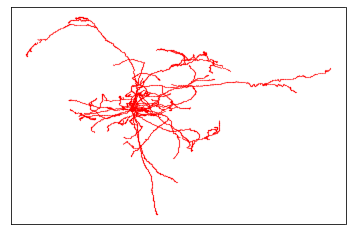

In [204]:
plt.scatter(rot_xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(rot_xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(rot_xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_bf_axons.svg", format='svg')
plt.show()

## Next section
The below section then talkes a folder containing these excel file

For each axonal excel file, merge subregions with the common parent region (ie, SSp-bfd Layers 1, 2/3, 4, etc becomes SSp-bfd), then save as another excel file named ALxxx_parent.xls

In [ ]:
axon_files=[os.path.join('D:\\Complete_points\\' ,i) for i in files if 'axons_region_with_counts' in i]
all_mice= set([na.find_mousename(i) for i in files])
all_mice=list(all_mice)

out_dir= 'D:\\Complete_points\\'

In [ ]:
# Creates pd with parent structure (1 level up) for all
for i in axon_files:
    axon_bar=pd.read_excel(i).sort_values(by=['Total_counts'])
    new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
    new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)
    mouse_name= na.find_mousename(i)
    result= parent_df(new_axonpd)
    result.to_excel(f'{out_dir}{mouse_name}_parent.xls')  

## Makes individual bar graph ##

In [4]:
files=[os.path.join('D:\\Complete_points\\' ,i) for i in files if 'region_with_counts' in i]

In [5]:
test= [i for i in files if re.search('AL140', i) ] # Need to manually enter the mouse identifier, or write a loop looping through them
axon= test[0]
dendrite=test[1]
mousename=na.find_mousename(axon)

In [6]:
axon_bar=pd.read_excel(axon).sort_values(by=['Total_counts'])
dendrite_bar=pd.read_excel(dendrite).sort_values(by=['Total_counts'])

In [7]:
new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)

NameError: name 'new_axonpd' is not defined

In [8]:
new_dendritepd= na.atlas_labels.merge(dendrite_bar, on= 'acronym')
new_dendritepd.sort_values(by= 'Total_counts',axis=0, inplace=True)

### order by total amount of a parent region 

In [9]:
def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'Total_counts': grouped_pd.Total_counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['Total_counts'], ascending=True, inplace=True)
    # result is the final pd

    return result

In [10]:
result= parent_df(new_axonpd)
new_order=result.id.to_numpy()
#new_order

array([      402,      1011,       985,       485,       337,      1009,
             776, 182305689,       361, 312782546,       417,       378,
             369,       301,       329])

In [11]:
old_order= new_axonpd.parent_structure_id.to_numpy()   
#old_order

array([9.85000000e+02, 9.85000000e+02, 3.29000000e+02, 3.29000000e+02,
       3.29000000e+02, 3.29000000e+02, 3.29000000e+02, 3.29000000e+02,
       3.37000000e+02, 3.37000000e+02, 3.69000000e+02, 3.69000000e+02,
       3.61000000e+02, 3.61000000e+02, 1.82305689e+08, 1.82305689e+08,
       3.78000000e+02, 3.78000000e+02, 3.78000000e+02, 1.01100000e+03,
       4.02000000e+02, 3.12782546e+08, 3.12782546e+08, 3.12782546e+08,
       4.17000000e+02, 4.17000000e+02, 4.17000000e+02, 4.85000000e+02,
       1.00900000e+03, 7.76000000e+02, 3.01000000e+02])

In [12]:
new_array= np.zeros_like(old_order)
for i, j in enumerate(new_order):
    new_array[old_order==j]=i

#new_array
# generate new order for the detailed pd

array([ 2.,  2., 14., 14., 14., 14., 14., 14.,  4.,  4., 12., 12.,  8.,
        8.,  7.,  7., 11., 11., 11.,  1.,  0.,  9.,  9.,  9., 10., 10.,
       10.,  3.,  5.,  6., 13.])

In [13]:
new_axonpd['new_order']= new_array
new_axonpd.sort_values('new_order', inplace=True)

In [14]:
new_axonpd.sort_values(by=['new_order', 'region_id'], ascending=[True, False] ,inplace=True)
# sort by new order first (total amount within the same parent id), and then within each substructure, sort by layer 1 to layer 6

In [15]:
def plot_hist(pd_axon, pd_dendrite, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=1,
        row_heights=[0.9, 0.1],
        row_titles=['Axons', 'Dendrites']
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts']/1000, # units now in milimeters
        marker_color='black',
        name='',
        text=pd_dendrite['region_id'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )

    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1000, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()
    # plotly.offline.plot(fig,filename='D:/'+ mousename+'/barplot.html')
    fig.write_image(f"{results_dir} {mousename}.svg")
    fig.write_html(f"{results_dir} {mousename}.html")

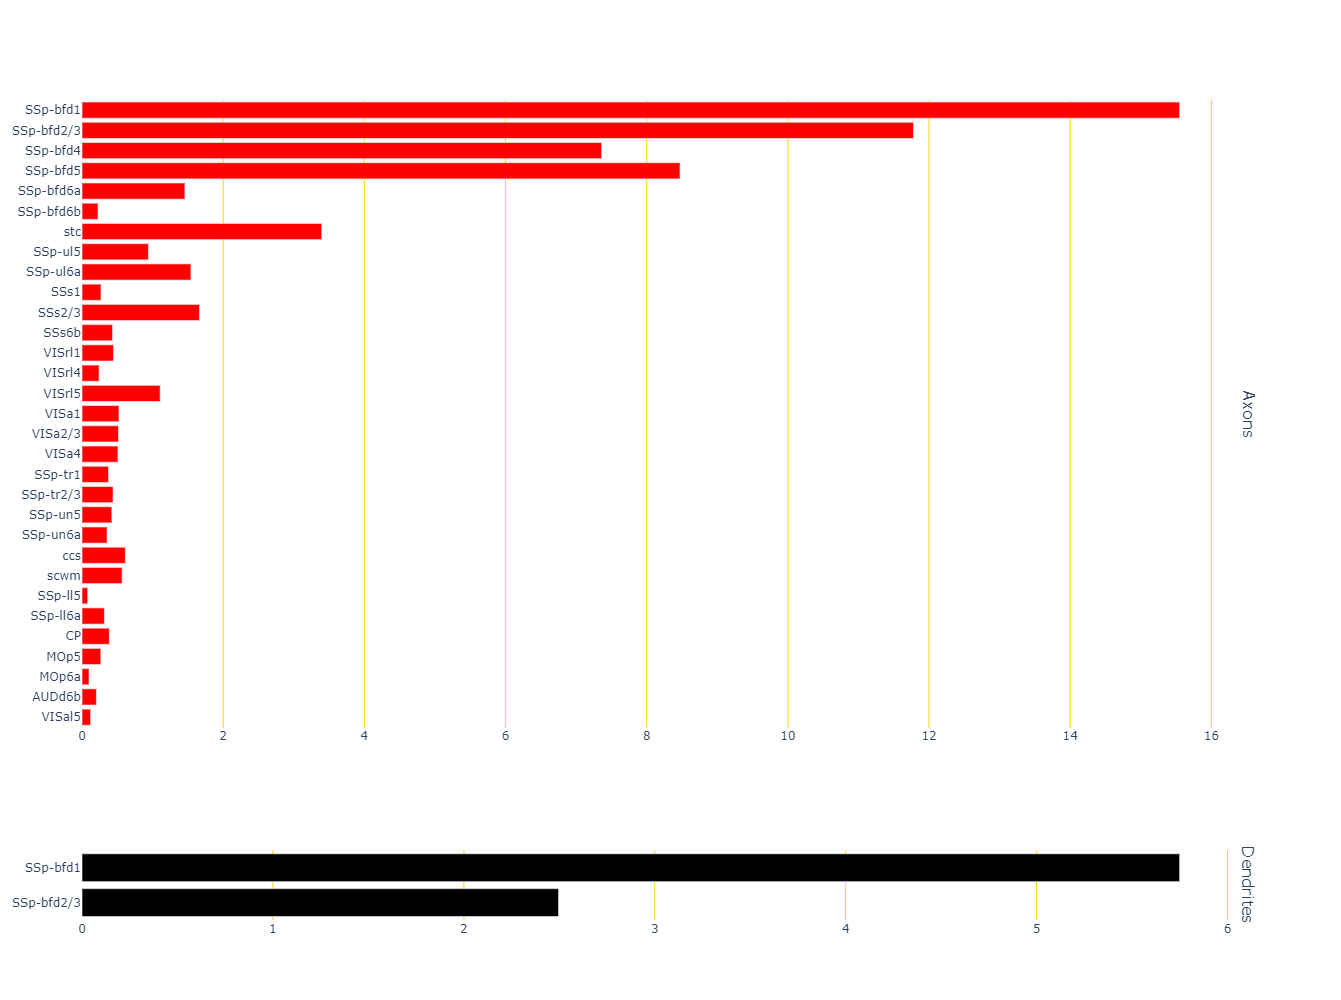

In [16]:
plot_hist(new_axonpd,new_dendritepd,mousename)

## Final summary annotated heatmap

In [ ]:
#define useful functions

def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['Total_counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'Total_counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def sort_id(df):
    #pick out id that are present in the df and sort them by graph order
    #this puts relevant regions together(ie, all layers of S1bf will be together, etc)
    atlas_ref=na.atlas_labels[na.atlas_labels['id'].isin(df.columns)]
    sorted_id=[x for _,x in sorted(zip(atlas_ref['graph_order'],atlas_ref['id']))]
    return sorted_id

In [ ]:
#find all relevant files
folder= 'M:\\analysis\Yanqi_Liu\Complete_points'
files= [ i for i  in os.listdir(folder) if 'with_counts' in i]
parent_axons= [ i for i  in os.listdir(folder) if 'parent' in i]

In [ ]:
axonal_df= combine_df(folder, parent_axons)
# keep Nan for heatmap display purposes

In [ ]:
axonal_df.sort_index(axis=1)
new_colorder= axonal_df.sum()
# new column order would be the region with greatest amount goes first, ie: bfd, trunk, visc, etc

new_colorder.sort_values(ascending=False, inplace=True)
# finds the new coloumn order
axonal_df=axonal_df[new_colorder.index]
# sort by new column order

In [ ]:
average= axonal_df.sum()/10
# 10 cells in total
avg=average.to_numpy()

avg=np.reshape(avg,(1,28))
# 28 region item in total
avg.shape

df_average = pd.DataFrame(avg, columns=axonal_df.columns, index=['Average'])
df_average

In [ ]:
final= axonal_df.append(df_average)
final.to_excel('axonal_df_parent.xls')

final=final[::-1] 
# so that average row shows up last when plotting

In [ ]:
# Dataframe preparation done, now to plot annotated heatmap
x=final.columns.to_list()
y=final.index.to_list()

full_name=[]
for i in x:
    name=na.atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

In [ ]:
parent_acronyms= {'Acronyms': x, 'Full name': full_name}
acronym_df= pd.DataFrame(data=parent_acronyms)
acronym_df.to_excel('acronym_parent.xls')
# Generate an excel file of acronyms as well as their full name (for list of acronym in appendix)

In [ ]:

fig = ff.create_annotated_heatmap(z=final.values, 
                                  colorscale='Portland',
                                  font_colors=['white'],
                                  zmax= 10000,
                                  zmin=100,
                                  y=y,
                                  x=x,
                                  hoverongaps = False,
                                  text=full_name
                                 )
fig.update_xaxes(visible=True, showgrid=False)
fig.update_yaxes(visible=True, showgrid=False)

fig.update_layout(
    width = 2000, height = 600,
    autosize = True,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

fig.write_image("fig1.svg")